In [1]:
from helper.plots import plot_phate_animations

# Embedding Trajectories
Compare embedding trajectories

In [2]:
dataset_name = 'mnist'

run_ids = [
#    "run-0011-CNN_mnist_32_0.9776",
#    "run-0012-CNN_mnist_32_0.9768"
#    "run-0007-CNN_mnist_128_0.9851",

#    "run-0016-CNN_cifar10_128_0.8093", # Seed 42, SAM, Residual
    "run-0017-CNN_cifar10_128_0.8072", # Seed 42, SAM
#    "run-0018-CNN_cifar10_128_0.8499", # Seed 42, Residual
    "run-0019-CNN_cifar10_128_0.8487", # Seed 42

#    "run-0020-CNN_cifar10_128_0.8079", # Seed 11, SAM, Residual
    "run-0021-CNN_cifar10_128_0.8054", # Seed 11, SAM
#    "run-0022-CNN_cifar10_128_0.8519", # Seed 11, Residual
    "run-0023-CNN_cifar10_128_0.8509", # Seed 11

#    "run-0024-CNN_cifar10_128_0.8062",
    "run-0025-CNN_cifar10_128_0.8062",
#    "run-0026-CNN_cifar10_128_0.8504",
    "run-0027-CNN_cifar10_128_0.8503",
]

In [3]:
titles = [
#    "Seed 42, SAM, Residual 0.8093",
    "Seed 42, SAM, 0.8072",
#    "Seed 42, SGD, Residual 0.8499",
    "Seed 42, SGD, 0.8487",
#    "Seed 11, SAM, Residual 0.8079",
    "Seed 11, SAM, 0.8054",
#    "Seed 11, SGD, Residual 0.8519",
    "Seed 11, SGD, 0.8509",
    
#    "Seed 6, SAM, Residual 0.0.8062",
    "Seed 6, SAM, 0.8062",
#    "Seed 6, SGD, Residual 0.8504",
    "Seed 6, SGD, 0.8503",
]

In [5]:
from helper.visualization import Run

runs = []
for run_id in run_ids:
    runs.append(Run(run_id, dataset_name))

### Trainings:

In [ ]:
for run in runs:
    run.plot_training_records()

## PHATE Embedding Trajectories

In [6]:
from helper.visualization import mphate_on_runs

animations = mphate_on_runs(runs, titles)

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 13.00 seconds.
  Calculated multislice kernel in 18.74 seconds.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.05 seconds.
  Running PHATE on precomputed affinity matrix with 1500 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculated optimal t in 2.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 20.28 seconds.
Calculated M-PHATE in 44.83 seconds.


In [7]:
from helper.plots import soft_smooth 

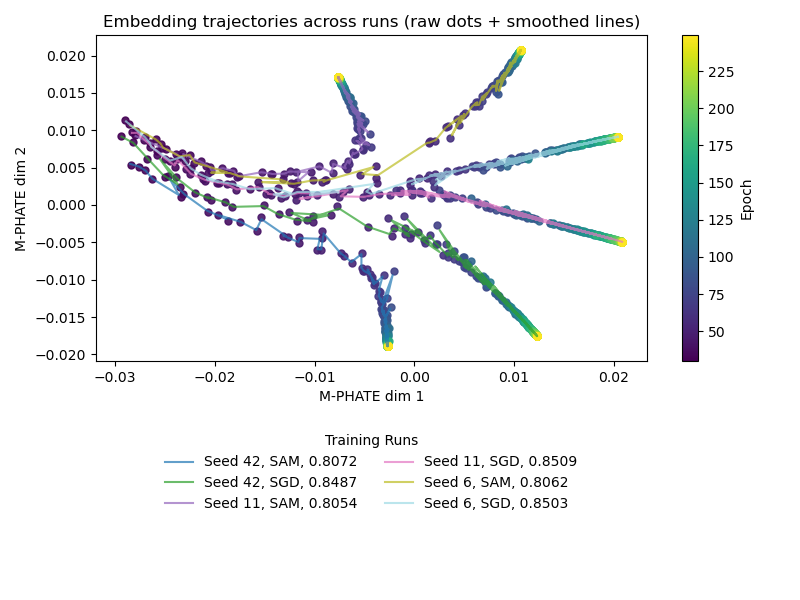

In [8]:
%matplotlib ipympl
%matplotlib widget

plot_phate_animations(animations, smooth_window=7, smooth_alpha=0.85, start_epoch=30)

In [9]:
denoised = animations[0].denoise(window_size=5, blend=0.7, do_embedding_drift=True, do_cka_similarities=False)

In [ ]:
print(len(animations[0].projections))
animations[0].projections[0].shape

In [ ]:
print(len(denoised.projections))
denoised.projections[0].shape

In [ ]:
denoised.evaluate()

In [ ]:
n = 0
print(f"{titles[n]}\n")
animations[n].evaluate()

In [ ]:
list_drifts, list_cka = [], [] 

for i, run in enumerate(titles):
    print(f"{titles[i]}\n")
    drift, cka = animations[i].evaluate(verbose=False)
    list_drifts.append(drift); list_cka.append(cka)
    print(f"Mean Drift Similarity: {drift}, Mean Similarity to CKA: {cka}")

# Prediction Similarity

In [11]:
from helper.visualization import compute_prediction_similarities
from helper.plots import plot_prediction_similarity_heatmap

In [12]:
similarities = compute_prediction_similarities(runs, similarity="cosine")
plot_prediction_similarity_heatmap(similarities, run_titles=titles)

interactive(children=(IntSlider(value=0, description='Epoch', max=49), Output()), _dom_classes=('widget-intera…

In [ ]:
import matplotlib
matplotlib.pyplot.close()

In [13]:
similarities = compute_prediction_similarities(runs[::-2], similarity="cosine")
plot_prediction_similarity_heatmap(similarities, run_titles=titles[::-2], figsize=(6,5))

interactive(children=(IntSlider(value=0, description='Epoch', max=49), Output()), _dom_classes=('widget-intera…

In [15]:
from helper.visualization import mphate_on_predictions

In [16]:
pred_animations = mphate_on_predictions(runs, titles=titles)

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 6.03 seconds.
  Calculated multislice kernel in 10.54 seconds.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Running PHATE on precomputed affinity matrix with 300 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 49
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.13 seconds.
Calculated M-PHATE in 11.36 seconds.


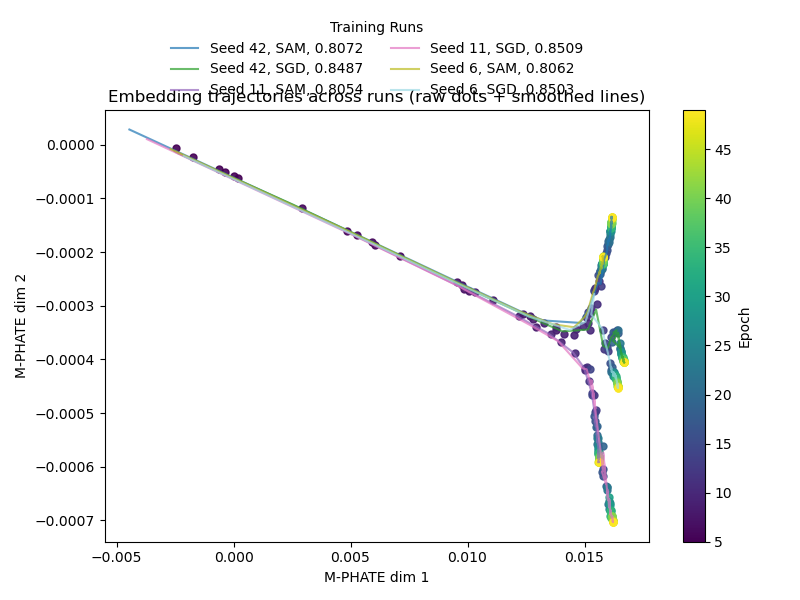

In [21]:
plot_phate_animations(pred_animations, start_epoch=5, legend_dist=-1.0)

# PHATE on Model weights

In [18]:
from helper.visualization import mphate_on_model_weights

animations_model = mphate_on_model_weights(runs, titles=titles)

trainings/run-0017-CNN has 51 files
Found 51 checkpoint files.


Loading model checkpoints:   0%|          | 0/51 [00:00<?, ?it/s]

trainings/run-0019-CNN has 51 files
Found 51 checkpoint files.


Loading model checkpoints:   0%|          | 0/51 [00:00<?, ?it/s]

trainings/run-0021-CNN has 51 files
Found 51 checkpoint files.


Loading model checkpoints:   0%|          | 0/51 [00:00<?, ?it/s]

trainings/run-0023-CNN has 51 files
Found 51 checkpoint files.


Loading model checkpoints:   0%|          | 0/51 [00:00<?, ?it/s]

trainings/run-0025-CNN has 51 files
Found 51 checkpoint files.


Loading model checkpoints:   0%|          | 0/51 [00:00<?, ?it/s]

trainings/run-0027-CNN has 51 files
Found 51 checkpoint files.


Loading model checkpoints:   0%|          | 0/51 [00:00<?, ?it/s]

MemoryError: Unable to allocate 2.67 GiB for an array with shape (6, 51, 2340426) and data type float32

In [ ]:
# Optional: smooth for visualization only
plot_phate_animations(animations_model, smooth_window=5, smooth_alpha=0.9, start_epoch=0)

# Linear Mode Connectivity (LMC)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#from helper.neuro_viz import compute_lmc_loss_path
from helper.visualization import linear_mode_connectivity_path

def compute_LMC(runs, idx_1, idx_2, titles, model, dataset_name, device='cpu', num_points=10, ):
    print(f"Compute LMC between ({titles[idx_1]}) and ({titles[idx_2]})")

    info1 = runs[idx_1].results["model_info"]
    info2 = runs[idx_2].results["model_info"]
    
    assert info1 == info2, f"Model architectures differ:\n{info1}\n{info2}"
    print("Same architecture:")
    print(runs[idx_1].results["model_info"])

    assert repr(model_arch) == runs[idx_1].results["model_info"], "Wrong model"

    path = linear_mode_connectivity_path(runs[idx_1], runs[idx_2], num_points=num_points)

    losses = compute_lmc_loss_path(path, model, dataset_name, device=device)

    return losses

In [ ]:
from helper.vision_classification import init_mlp_for_dataset, init_cnn_for_dataset

model = init_cnn_for_dataset(dataset_name, conv_dims=[64, 128, 256], kernel_sizes=[5, 3, 3], hidden_dims=[256, 128], dropout=0.2, residual=False).to(device)

In [ ]:
lmc_results = {}

In [ ]:
for i in range(6):
    for j in range(6):
        if i == j:
            continue
        # skip if already computed in either order
        if (i, j) in lmc_results or (j, i) in lmc_results:
            continue
        print(f"Computing LMC for runs {i} → {j}")
        lmc_results[(i, j)] = compute_LMC(
            runs, i, j, titles, model, dataset_name, device, num_points=3
        )
        break

In [ ]:
import numpy as np
print(np.array(lmc_results[(0,1)]).min(), np.array(lmc_results[(0,1)]).max())

In [ ]:
import matplotlib.pyplot as plt

# lmc_results is a dict mapping (i,j) → list of losses
fig, ax = plt.subplots(figsize=(10, 6))

for (i, j), losses in lmc_results.items():
    ax.plot(
        losses,
        label=f"{titles[i]} ↔ {titles[j]}",
        alpha=0.8
    )

ax.set_xlabel("Interpolation index")
ax.set_ylabel("Loss")
ax.set_title("LMC loss paths for all run‐pairs")
ax.set_ylim(bottom=0)
ax.legend(
    title="Run pairs",
    loc="upper right",
    bbox_to_anchor=(1.3, 1),
    ncol=1,
    frameon=False
)
plt.tight_layout()
plt.show()

In [ ]:
for i, run in enumerate(runs):
    print(titles[i], ": ", run.results["val_losses"][-1])

In [ ]:
import torch
from copy import deepcopy
from tqdm import tqdm
from helper.neuro_viz import Loss, repopulate_model_fixed

def compute_lmc_loss_path(
    weight_path: list[np.ndarray],
    model: torch.nn.Module,
    dataset_name: str,
    device: str = 'cpu',
    loss_name: str = 'test_loss',
    whichloss: str = 'crossentropy',
    bn_recal_batches: int = 100
):
    loss_obj = Loss(dataset_name, device)
    losses = []
    model.to(device)

    for flat in tqdm(weight_path, desc="Compute LMC losses"):
        weights = torch.as_tensor(flat, dtype=torch.float32, device=device)
        with torch.no_grad():
            model = repopulate_model_fixed(weights.clone(), model)
        loss = loss_obj.get_loss(model, loss_name, whichloss).detach()
        print(loss)
        losses.append(loss.item())

    return losses

In [ ]:
flat = runs[0].get_flattened_weights()[0]
weights = torch.as_tensor(flat, device=device)
loss_obj = Loss(dataset_name, device)
with torch.no_grad():
    model = repopulate_model_fixed(weights.clone(), model)
loss = loss_obj.get_loss(model, 'test_loss', 'crossentropy').detach()
print(loss)

In [ ]:
flat[:10]